In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "Nin-like"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn019631,MEDGSFTPNTLLETLSDNTMDFDLMDELFYDGYWLETTEGPNFWQS...,940,1
1,Achn045931,MHIIVSKYIKDFGYDLSKFDRAKNLTLSPIIRIFDQQLSSTDTFDH...,263,1
2,Achn046361,MAEYPLAHFARKYRLKGCFAINLRSKYTGNDDYVLEIFLPDSNKDK...,460,1
3,Achn046371,MAVLLKQEKNDNKAHKKASVEMKRDLRLLLNIYKLPLALTWVSCGA...,642,1
4,Achn046381,MAVILKQEMNNNNAHQYAFLEIRWVLDRVRGIYKLPLALTWVPCGA...,652,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
3581,0.002312,0.003468,0.002312,0.004624,0.002312,0.004624,0.000000,0.001156,0.005780,0.008092,...,0.001156,0.000000,0.001156,0.001156,0.002312,0.001156,0.002312,0.0,0.0,0.002312
2533,0.003436,0.003436,0.003436,0.000000,0.006873,0.003436,0.000000,0.000000,0.000000,0.010309,...,0.000000,0.003436,0.000000,0.000000,0.003436,0.003436,0.000000,0.0,0.0,0.000000
4587,0.009404,0.006270,0.003135,0.003135,0.000000,0.006270,0.003135,0.000000,0.000000,0.000000,...,0.003135,0.000000,0.003135,0.000000,0.000000,0.006270,0.000000,0.0,0.0,0.000000
1712,0.024096,0.003012,0.006024,0.003012,0.006024,0.003012,0.003012,0.012048,0.003012,0.012048,...,0.000000,0.000000,0.000000,0.006024,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2122,0.008032,0.004016,0.000000,0.000000,0.000000,0.000000,0.000000,0.008032,0.000000,0.000000,...,0.004016,0.000000,0.004016,0.000000,0.004016,0.000000,0.000000,0.0,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4401, 441)
X_test: (1101, 441)
y_train: (4401,)
y_test: (1101,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - accuracy: 0.5156 - loss: 0.6931

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5223 - loss: 0.6923   

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5749 - loss: 0.6850 - val_accuracy: 0.9171 - val_loss: 0.4928


Epoch 2/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8594 - loss: 0.5429

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771 - loss: 0.4255 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8878 - loss: 0.3735 - val_accuracy: 0.9376 - val_loss: 0.1629


Epoch 3/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.1361

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9592 - loss: 0.1367

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9560 - loss: 0.1366

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9560 - loss: 0.1366 - val_accuracy: 0.9557 - val_loss: 0.1130


Epoch 4/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.1351

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9608 - loss: 0.1042 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9621 - loss: 0.1036

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9621 - loss: 0.1037 - val_accuracy: 0.9614 - val_loss: 0.1030


Epoch 5/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0694

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9702 - loss: 0.0850 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.0849

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.0849 - val_accuracy: 0.9535 - val_loss: 0.1310


Epoch 6/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0654

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9574 - loss: 0.1041 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9644 - loss: 0.0922

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9645 - loss: 0.0919 - val_accuracy: 0.9523 - val_loss: 0.1434


Epoch 7/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0955

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9740 - loss: 0.0872 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0831

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0828 - val_accuracy: 0.9682 - val_loss: 0.0989


Epoch 8/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.1014

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9805 - loss: 0.0642 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9825 - loss: 0.0584

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9825 - loss: 0.0584 - val_accuracy: 0.9569 - val_loss: 0.1217


Epoch 9/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0289

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9836 - loss: 0.0629 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0551

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0549 - val_accuracy: 0.9637 - val_loss: 0.1221


Epoch 10/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0660

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0587 

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0526

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9846 - loss: 0.0522 - val_accuracy: 0.9705 - val_loss: 0.0997


Epoch 11/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0147

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0272 

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0353

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0357 - val_accuracy: 0.9659 - val_loss: 0.1248


Epoch 12/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0428

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0259 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0267

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0267 - val_accuracy: 0.9694 - val_loss: 0.1241


Epoch 13/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0901

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0284 

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0232

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0231 - val_accuracy: 0.9648 - val_loss: 0.1244


Epoch 14/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0058

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0123

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0135 - val_accuracy: 0.9694 - val_loss: 0.1161


Epoch 15/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0062

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0128

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0137 - val_accuracy: 0.9659 - val_loss: 0.1304


Epoch 16/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0798

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0218 

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0198

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0198 - val_accuracy: 0.9659 - val_loss: 0.1405


Epoch 17/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0270

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0129 

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0121

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0122 - val_accuracy: 0.9591 - val_loss: 0.1671


Epoch 18/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0113

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0058 

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0071

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0074 - val_accuracy: 0.9625 - val_loss: 0.1639


Epoch 19/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0140

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0352 

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9865 - loss: 0.0353

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.0350 - val_accuracy: 0.9682 - val_loss: 0.1367


Epoch 20/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0294

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0142

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0142 - val_accuracy: 0.9637 - val_loss: 0.1585



[Train Accuracy: 99.40% - Test Accuracy: 96.09%]


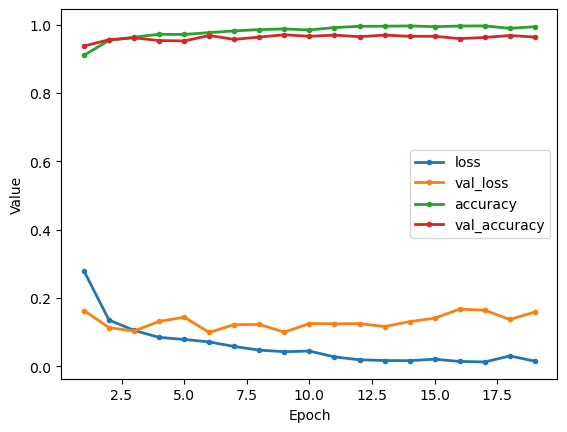

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
3581,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2533,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.003448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4587,0.006289,0.0,0.0,0.003145,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1712,0.006042,0.0,0.0,0.000000,0.0,0.0,0.0,0.003021,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2122,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4401, 8765)
X_test: (1101, 8765)
y_train: (4401,)
y_test: (1101,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,244,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,287,361 (8.73 MB)

 Trainable params: 2,287,361 (8.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 35s 655ms/step - accuracy: 0.4688 - loss: 0.6932

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4895 - loss: 0.6931   

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4993 - loss: 0.6929

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5207 - loss: 0.6925

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5477 - loss: 0.6912

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5714 - loss: 0.6890

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5940 - loss: 0.6854

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6143 - loss: 0.6797

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6276 - loss: 0.6741 - val_accuracy: 0.9569 - val_loss: 0.3114


Epoch 2/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9531 - loss: 0.3332

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9539 - loss: 0.2897 

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9550 - loss: 0.2649

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9563 - loss: 0.2434

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9582 - loss: 0.2250

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9602 - loss: 0.2095

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9619 - loss: 0.1952

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9632 - loss: 0.1848

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9642 - loss: 0.1782 - val_accuracy: 0.9796 - val_loss: 0.0535


Epoch 3/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.0450

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9951 - loss: 0.0223 

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9956 - loss: 0.0200

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9955 - loss: 0.0194

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9953 - loss: 0.0192

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9949 - loss: 0.0195

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947 - loss: 0.0196

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9946 - loss: 0.0197 - val_accuracy: 0.9864 - val_loss: 0.0360


Epoch 4/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0108

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0065 

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0070

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0075

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0075

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0073

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0071

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0069 - val_accuracy: 0.9898 - val_loss: 0.0301


Epoch 5/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0023

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0021 

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0023

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0024

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0024 - val_accuracy: 0.9875 - val_loss: 0.0398


Epoch 6/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0012

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0017 

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0021

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9898 - val_loss: 0.0315


Epoch 7/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.0949e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9715e-04 

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0728e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9358e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5632e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7769e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7986e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7764e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.7701e-04 - val_accuracy: 0.9921 - val_loss: 0.0296


Epoch 8/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.0537e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5630e-04 

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2282e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0544e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9607e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9062e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9159e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9142e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9168e-04 - val_accuracy: 0.9921 - val_loss: 0.0306


Epoch 9/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.9655e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1859e-04 

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0564e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8391e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1807e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2486e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2401e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1686e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.1570e-04 - val_accuracy: 0.9898 - val_loss: 0.0394


Epoch 10/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.4691e-05

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0579e-04 

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5934e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8812e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0024e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0805e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1165e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1497e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1676e-04 - val_accuracy: 0.9909 - val_loss: 0.0350


Epoch 11/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 8.2274e-05

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6690e-04 

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8764e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9229e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9124e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9053e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9195e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9281e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9342e-04 - val_accuracy: 0.9909 - val_loss: 0.0302


Epoch 12/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.0731e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1353e-04 

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3638e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4944e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5197e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5557e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5732e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5974e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6210e-04 - val_accuracy: 0.9921 - val_loss: 0.0325


Epoch 13/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.1425e-05

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2446e-04 

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4522e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6423e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9350e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3224e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5991e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7839e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8198e-04 - val_accuracy: 0.9852 - val_loss: 0.0525


Epoch 14/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.9105e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0875e-04 

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6030e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8075e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3101e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9645e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7463e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5678e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4808e-04 - val_accuracy: 0.9909 - val_loss: 0.0334


Epoch 15/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.1629e-05

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0038e-04 

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.3392e-05

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8185e-05

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4418e-05

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2127e-05

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0188e-05

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8452e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.7387e-05 - val_accuracy: 0.9898 - val_loss: 0.0387


Epoch 16/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.6975e-05

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5816e-05 

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9989e-05

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9028e-05

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7493e-05

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7086e-05

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6634e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.6273e-05 - val_accuracy: 0.9898 - val_loss: 0.0387


Epoch 17/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.6085e-05

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7165e-05 

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0142e-05

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3183e-05

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4251e-05

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4811e-05

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5131e-05

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5026e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.4933e-05 - val_accuracy: 0.9898 - val_loss: 0.0399



[Train Accuracy: 100.00% - Test Accuracy: 99.27%]


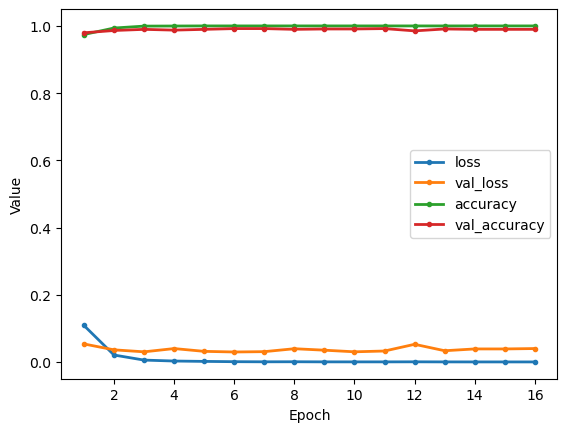

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
3581,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2533,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4587,0.003155,0.0,0.0,0.003155,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1712,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2122,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      37,435,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,476,353 (142.96 MB)

 Trainable params: 37,476,353 (142.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 43s 802ms/step - accuracy: 0.4531 - loss: 0.6931

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.4688 - loss: 0.6931 

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.4757 - loss: 0.6931

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.4808 - loss: 0.6931

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.4821 - loss: 0.6932

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.4834 - loss: 0.6932

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.4854 - loss: 0.6931

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.4868 - loss: 0.6931

 9/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.4875 - loss: 0.6931

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.4879 - loss: 0.6930

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.4890 - loss: 0.6930

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.4903 - loss: 0.6929

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.4907 - loss: 0.6929

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.4914 - loss: 0.6928

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.4932 - loss: 0.6927

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.4955 - loss: 0.6926

17/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.4983 - loss: 0.6925

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.5018 - loss: 0.6924

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.5059 - loss: 0.6923

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.5102 - loss: 0.6922

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.5145 - loss: 0.6921

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.5191 - loss: 0.6919

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.5234 - loss: 0.6917

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.5277 - loss: 0.6915

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.5319 - loss: 0.6913

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.5360 - loss: 0.6911

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5400 - loss: 0.6909

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5441 - loss: 0.6907

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5483 - loss: 0.6904

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5525 - loss: 0.6901

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5568 - loss: 0.6898

32/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.5611 - loss: 0.6895

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5653 - loss: 0.6892

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5696 - loss: 0.6888

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5737 - loss: 0.6884

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5777 - loss: 0.6880

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5817 - loss: 0.6876

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5855 - loss: 0.6871

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5893 - loss: 0.6866

40/55 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5930 - loss: 0.6860

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.5967 - loss: 0.6854

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6003 - loss: 0.6848

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6039 - loss: 0.6842

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6074 - loss: 0.6835

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6109 - loss: 0.6827

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6143 - loss: 0.6819

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6176 - loss: 0.6811

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6209 - loss: 0.6802

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6241 - loss: 0.6793

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6273 - loss: 0.6784

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6304 - loss: 0.6774

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6335 - loss: 0.6763

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6365 - loss: 0.6752

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6394 - loss: 0.6741

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6423 - loss: 0.6729

55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.6451 - loss: 0.6717 - val_accuracy: 0.9580 - val_loss: 0.3353


Epoch 2/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.9531 - loss: 0.3375

 2/55 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.9609 - loss: 0.3295 

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9635 - loss: 0.3228

 4/55 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.9658 - loss: 0.3154

 5/55 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.9658 - loss: 0.3102

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9663 - loss: 0.3044

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9669 - loss: 0.2990

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9677 - loss: 0.2945

 9/55 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9686 - loss: 0.2902

10/55 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9695 - loss: 0.2862

11/55 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9705 - loss: 0.2821

12/55 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9711 - loss: 0.2783

13/55 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9717 - loss: 0.2743

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9723 - loss: 0.2703

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9728 - loss: 0.2666

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9732 - loss: 0.2628

17/55 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9736 - loss: 0.2591

18/55 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9741 - loss: 0.2554

19/55 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9745 - loss: 0.2518

20/55 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9750 - loss: 0.2482

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9754 - loss: 0.2448

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9759 - loss: 0.2414

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9762 - loss: 0.2383

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9765 - loss: 0.2352

25/55 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9768 - loss: 0.2322

26/55 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9771 - loss: 0.2294

27/55 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9773 - loss: 0.2266

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9776 - loss: 0.2238

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9778 - loss: 0.2212

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9781 - loss: 0.2186

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9783 - loss: 0.2161

32/55 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9785 - loss: 0.2137

33/55 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9787 - loss: 0.2113

34/55 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9789 - loss: 0.2090

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9791 - loss: 0.2068

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9792 - loss: 0.2046

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9794 - loss: 0.2025

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9795 - loss: 0.2004

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9796 - loss: 0.1984

40/55 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9798 - loss: 0.1964

41/55 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9799 - loss: 0.1945

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9801 - loss: 0.1925

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9802 - loss: 0.1907

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9803 - loss: 0.1889

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9805 - loss: 0.1871

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9806 - loss: 0.1854

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9807 - loss: 0.1837

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9809 - loss: 0.1820

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9810 - loss: 0.1804

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9811 - loss: 0.1789

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9812 - loss: 0.1773

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9813 - loss: 0.1758

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9813 - loss: 0.1744

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9814 - loss: 0.1730

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9815 - loss: 0.1716

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.9816 - loss: 0.1703 - val_accuracy: 0.9898 - val_loss: 0.0534


Epoch 3/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 1.0000 - loss: 0.0105

 2/55 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9961 - loss: 0.0133 

 3/55 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9957 - loss: 0.0133

 4/55 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.9958 - loss: 0.0132

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9960 - loss: 0.0132

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9962 - loss: 0.0131

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9964 - loss: 0.0129

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9964 - loss: 0.0129

 9/55 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9964 - loss: 0.0127

10/55 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9965 - loss: 0.0125

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9964 - loss: 0.0124

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9964 - loss: 0.0122

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9964 - loss: 0.0120

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9964 - loss: 0.0118

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9964 - loss: 0.0116

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9965 - loss: 0.0114

17/55 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9965 - loss: 0.0113

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9966 - loss: 0.0111

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9966 - loss: 0.0109

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9966 - loss: 0.0108

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9966 - loss: 0.0106

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9967 - loss: 0.0105

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9967 - loss: 0.0104

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9967 - loss: 0.0103

25/55 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9968 - loss: 0.0102

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9968 - loss: 0.0101

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9968 - loss: 0.0100

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9969 - loss: 0.0099

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9969 - loss: 0.0098

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9969 - loss: 0.0097

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9969 - loss: 0.0096

32/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9970 - loss: 0.0096

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9970 - loss: 0.0095

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9970 - loss: 0.0094

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9970 - loss: 0.0094

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9970 - loss: 0.0093

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9971 - loss: 0.0093

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9971 - loss: 0.0092

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9971 - loss: 0.0092

40/55 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9971 - loss: 0.0091

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9972 - loss: 0.0091

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9972 - loss: 0.0090

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9972 - loss: 0.0090

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9972 - loss: 0.0089

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9973 - loss: 0.0089

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9973 - loss: 0.0089

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9973 - loss: 0.0088

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9973 - loss: 0.0088

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9973 - loss: 0.0087

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9974 - loss: 0.0087

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9974 - loss: 0.0086

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9974 - loss: 0.0086

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9974 - loss: 0.0086

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9975 - loss: 0.0085

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9975 - loss: 0.0085

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.9728 - val_loss: 0.0608


Epoch 4/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0068

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0054

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0045

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0042

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0039

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 0.0037

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 0.0035

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0033

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0032

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0030

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0029

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0029

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0028

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0027

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0027

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0026

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0026

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0026

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0025

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0025

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0025

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0025

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0024

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0024

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0024

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0024

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0024

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0023

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0023

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0023

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0023

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0023

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 0.0023

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0023

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0022

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0022

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0022

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0022

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0022

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0022

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0022

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0022

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0022

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0021

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0021

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0021

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0021

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0021

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0021

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0021

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0021

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0021

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0021

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0021

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0020

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9852 - val_loss: 0.0351


Epoch 5/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 13s 248ms/step - accuracy: 1.0000 - loss: 0.0012

 2/55 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 0.0011 

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 0.0010

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 9.4543e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 9.0198e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 8.6125e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 8.3864e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 8.1961e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 8.0521e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 7.9473e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 7.8403e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 7.7346e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 7.6358e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 7.5400e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 7.4635e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 7.3988e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 7.3387e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 7.2818e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 7.5168e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 7.7110e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 7.8743e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 8.0109e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 8.1252e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 8.2216e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 8.3057e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.3736e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.4291e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.4792e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.5215e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.5547e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 8.5805e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 8.5999e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 8.6197e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 8.7342e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 8.8380e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 8.9330e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 9.0174e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9999 - loss: 9.0931e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9999 - loss: 9.1600e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9999 - loss: 9.2217e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9999 - loss: 9.2792e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9999 - loss: 9.3387e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9999 - loss: 9.3945e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9999 - loss: 9.4482e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9999 - loss: 9.4964e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9999 - loss: 9.5412e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9999 - loss: 9.5857e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9999 - loss: 9.6285e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9999 - loss: 9.6665e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9999 - loss: 9.6996e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9999 - loss: 9.7291e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9999 - loss: 9.7548e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9999 - loss: 9.7778e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9999 - loss: 9.7983e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9999 - loss: 9.8157e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9999 - loss: 9.8324e-04 - val_accuracy: 0.9898 - val_loss: 0.0235


Epoch 6/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 8.1501e-04

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.8332e-04

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.3268e-04

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.3271e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.2565e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.1340e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.9809e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.8446e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 5.7401e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 5.6589e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 5.5824e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 5.5006e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 5.4356e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 5.3680e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 5.2991e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 5.2518e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 5.2229e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.1938e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.1595e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.1686e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.1702e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.1645e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.1590e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.1504e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 5.1372e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 5.1225e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 5.1062e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 5.0924e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 5.0771e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 5.0599e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 5.0418e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 5.0236e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 5.0078e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 4.9910e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 4.9749e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 4.9585e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 4.9419e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 4.9265e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 4.9111e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.8955e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.8794e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.8627e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.8463e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.8297e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.8131e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.7961e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.7817e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 4.7676e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 4.7534e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 4.7397e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 4.7255e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 4.7111e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 4.6982e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 4.6851e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 4.6726e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.6606e-04 - val_accuracy: 0.9852 - val_loss: 0.0326


Epoch 7/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 2.3379e-04

 2/55 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 4.2063e-04

 3/55 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 4.4830e-04

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.7897e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.8063e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 4.7866e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 4.9738e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 5.0650e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 5.0814e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 5.0774e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.0529e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 5.0205e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.9773e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.9338e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.8875e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.8469e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.8073e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 4.7665e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 4.7294e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 4.6907e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 4.6528e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 4.6139e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 4.5746e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 4.5373e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 4.5010e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 4.4658e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 4.4315e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 4.3973e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 4.3629e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 4.3290e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 4.2984e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 4.2732e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 4.2490e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 4.2255e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 4.2022e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 4.1796e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 4.1574e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 4.1356e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 4.1148e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 4.0940e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 4.0731e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 4.0524e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 4.0327e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 4.0135e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.9969e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.9801e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.9635e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.9468e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.9308e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.9150e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.8994e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.8841e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.8687e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.8534e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.8383e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 3.8237e-04 - val_accuracy: 0.9852 - val_loss: 0.0322


Epoch 8/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.3861e-05

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.0955e-04

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.3098e-04

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.3666e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.4095e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.4512e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.4881e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.5262e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.5587e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.5794e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.6008e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.6166e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.6297e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.6395e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.6430e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.6507e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.6547e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.6571e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.6577e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.6566e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.6563e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.6554e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.6542e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.6522e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.6514e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.6509e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.6516e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.6513e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.6507e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.6496e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.6484e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.6473e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6491e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6506e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6520e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6538e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6562e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6578e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6590e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6598e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.6609e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.6613e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.6611e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.6604e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.6595e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.6582e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.6567e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.6558e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.6546e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.6538e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.6542e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.6545e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.6545e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.6544e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.6543e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.6543e-04 - val_accuracy: 0.9852 - val_loss: 0.0345


Epoch 9/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 1.0000 - loss: 2.3224e-04

 2/55 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.8762e-04

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.7024e-04

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.7484e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.7672e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.7530e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.7717e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.7727e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.7766e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7660e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7497e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.7321e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7150e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.6974e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.6806e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.6640e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.6474e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.6320e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.6186e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.6079e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.5985e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.5898e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.5810e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.5729e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.5656e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.5601e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.5552e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.5514e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.5476e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.5441e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.5408e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.5407e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.5406e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.5399e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.5387e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.5368e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.5348e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.5328e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.5305e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.5400e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5483e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5560e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5627e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5688e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5741e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5788e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5827e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.5861e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.5891e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.5917e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.5949e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.5975e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.5997e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.6019e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.6036e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.6053e-04 - val_accuracy: 0.9875 - val_loss: 0.0239


Epoch 10/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 7.4890e-05

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 8.2038e-05

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 9.7815e-05

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.0559e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.0796e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.0958e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.0986e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.1126e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.1252e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.1361e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.1390e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.1395e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.1377e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.1461e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.1514e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.1599e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.1733e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.1832e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.1927e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.2018e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.2095e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.2147e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.2184e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.2212e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.2230e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.2243e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.2245e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.2237e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.2230e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.2221e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.2204e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.2188e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.2185e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.2183e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.2173e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.2166e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.2166e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.2166e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.2164e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.2162e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.2156e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.2149e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.2139e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.2127e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.2112e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.2099e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.2084e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.2067e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.2047e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.2026e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.2003e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1979e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1956e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1934e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1911e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.1888e-04 - val_accuracy: 0.9864 - val_loss: 0.0322


Epoch 11/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 1.0000 - loss: 9.9835e-05

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 9.4222e-05

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 9.0619e-05

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 8.6467e-05

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 8.1951e-05

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 8.3338e-05

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 8.3276e-05

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 8.2675e-05

 9/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 8.1953e-05

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 8.1184e-05

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 8.0501e-05

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.9652e-05

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.8937e-05

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.8294e-05

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.7622e-05

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.7128e-05

17/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.6766e-05

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.6969e-05

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.7029e-05

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.7030e-05

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 7.6938e-05

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 7.6830e-05

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 7.6800e-05

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 7.6755e-05

25/55 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 7.6732e-05

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 7.6713e-05

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 7.6790e-05

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 7.6857e-05

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 7.6912e-05

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 7.6998e-05

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 7.7078e-05

32/55 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 7.7613e-05

33/55 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 7.8116e-05

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.8573e-05

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.8958e-05

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.9339e-05

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.9675e-05

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.9962e-05

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.0224e-05

40/55 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.0446e-05

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.0650e-05

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.0813e-05

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.0947e-05

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.1075e-05

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 8.1169e-05

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 8.1229e-05

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 8.1266e-05

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 8.1289e-05

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 8.1299e-05

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 8.1304e-05

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 8.1298e-05

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 8.1274e-05

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 8.1245e-05

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 8.1207e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 8.1166e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 8.1127e-05 - val_accuracy: 0.9852 - val_loss: 0.0340


Epoch 12/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 1.0000 - loss: 3.5118e-05

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 3.2749e-05 

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.6792e-05

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.4595e-05

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 5.7239e-05

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 6.0353e-05

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.2056e-05

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 6.2637e-05

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.2913e-05

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.3098e-05

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.3047e-05

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 6.2820e-05

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 6.2793e-05

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 6.2929e-05

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 6.2939e-05

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 6.2840e-05

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.2738e-05

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 6.2658e-05

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.2773e-05

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.2935e-05

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.3047e-05

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.3123e-05

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.3199e-05

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.3253e-05

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 6.3304e-05

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 6.3342e-05

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 6.3445e-05

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 6.3512e-05

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 6.3572e-05

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 6.3671e-05

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 6.3811e-05

32/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 6.3895e-05

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 6.3977e-05

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 6.4071e-05

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 6.4135e-05

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 6.4163e-05

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 6.4170e-05

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 6.4180e-05

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 6.4172e-05

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 6.4222e-05

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 6.4249e-05

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 6.4251e-05

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 6.4250e-05

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 6.4231e-05

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 6.4216e-05

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 6.4193e-05

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 6.4182e-05

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 6.4217e-05

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 6.4249e-05

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 6.4266e-05

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 6.4282e-05

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 6.4310e-05

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 6.4319e-05

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 6.4315e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 6.4313e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 6.4311e-05 - val_accuracy: 0.9852 - val_loss: 0.0370



[Train Accuracy: 100.00% - Test Accuracy: 98.82%]


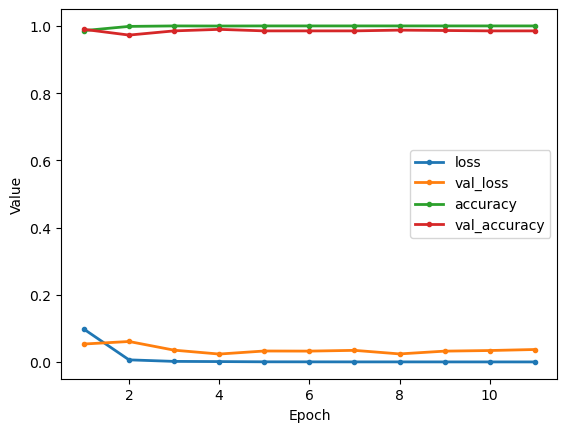

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/35 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

 5/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

13/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

18/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

 5/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

13/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

18/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/Nin-like/report_VZRGTJGY.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################